In [1]:
import pandas
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy

tfd = tfp.distributions

In [2]:
sns.set_theme()

In [3]:
frogs = pandas.read_csv('frogs.csv', sep='\t', dtype={'density': numpy.float32, 'surv': numpy.float32})

In [4]:
frogs.head()

,density,pred,size,surv,propsurv
0,10.0,no,big,9.0,0.9
1,10.0,no,big,10.0,1.0
2,10.0,no,big,7.0,0.7
3,10.0,no,big,10.0,1.0
4,10.0,no,small,9.0,0.9


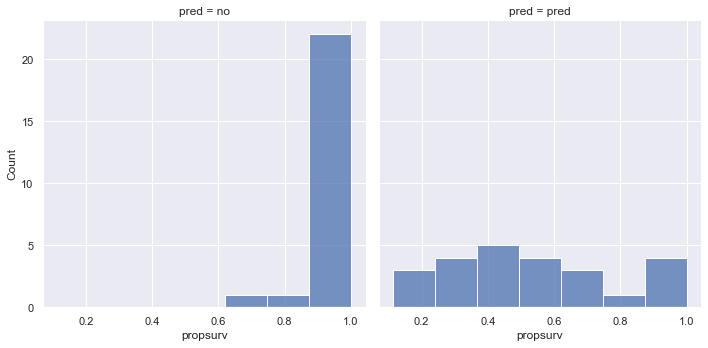

In [5]:
sns.displot(data=frogs, x='propsurv', col='pred')

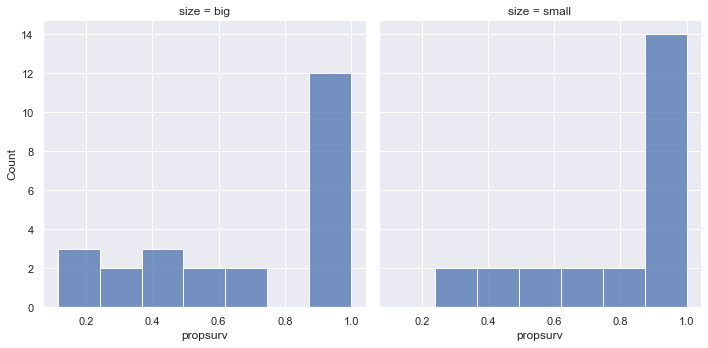

In [6]:
sns.displot(data=frogs, x='propsurv', col='size')

In [8]:
surv = tf.constant(frogs['surv'])
big_tank = tf.constant(frogs['size'] == 'big', tf.float32)
pred = tf.constant(frogs['pred'] == 'yes', tf.float32)

2021-11-03 12:33:31.786156: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
tf.get_logger().setLevel('ERROR')

## Simple Model

$$\begin{align}
\theta_i &\sim \operatorname{LogitNormal}(0.5, 2)\\
s_i &\sim \operatorname{Binomial}(N_i, \theta_i)
\end{align}
$$

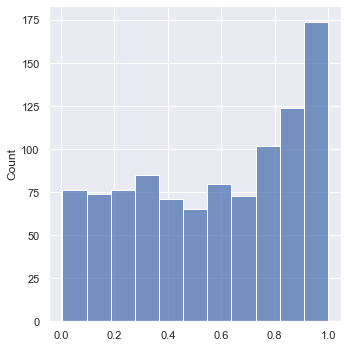

In [12]:
sns.displot(tfd.LogitNormal(0.5, 2).sample(1000).numpy())

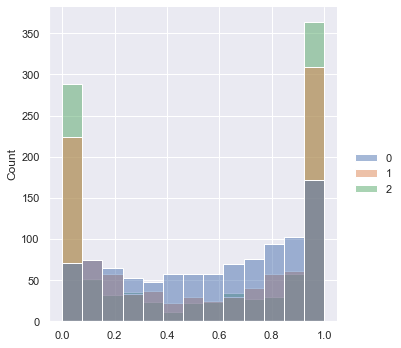

In [15]:
sns.displot(tfd.LogitNormal(0.5, [2, 4, 6]).sample(1000).numpy())

In [17]:
model = tfd.JointDistributionNamedAutoBatched({
    'theta': tfd.Independent(tfd.LogitNormal(0.5*tf.ones(frogs.shape[0]), 2)),
    's': lambda theta: tfd.Independent(tfd.Binomial(frogs['density'], probs=theta))
})

In [18]:
model.resolve_graph()

(('theta', ()), ('s', ('theta',)))

In [24]:
model.sample(3)

{'theta': <tf.Tensor: shape=(3, 48), dtype=float32, numpy=
 array([[0.25070485, 0.8849838 , 0.9726698 , 0.3345939 , 0.04289815,
         0.743765  , 0.9321073 , 0.76890767, 0.48404548, 0.9831492 ,
         0.8679998 , 0.9969816 , 0.8867942 , 0.67212665, 0.95158637,
         0.964478  , 0.9716575 , 0.9601581 , 0.91522205, 0.3018184 ,
         0.98624384, 0.9784788 , 0.99610245, 0.9509904 , 0.97095037,
         0.4144117 , 0.07510614, 0.6644594 , 0.96148133, 0.23806265,
         0.49170086, 0.9741353 , 0.65268767, 0.9586655 , 0.56373304,
         0.71313167, 0.90488577, 0.77886677, 0.6455966 , 0.9515068 ,
         0.27115405, 0.68141055, 0.79667675, 0.93013084, 0.296449  ,
         0.8096272 , 0.96637666, 0.61298835],
        [0.86203957, 0.8692752 , 0.12089875, 0.13728139, 0.53664297,
         0.6887969 , 0.59824014, 0.78698444, 0.9208908 , 0.98496115,
         0.92557716, 0.79088324, 0.9392315 , 0.24093997, 0.66190535,
         0.62346727, 0.9039001 , 0.83075297, 0.06368989, 0.83029306

In [25]:
model.log_prob(model.sample(3))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-89.754234, -79.66706 , -89.30952 ], dtype=float32)>

In [26]:
@tf.function
def log_prob(theta):
    return model.log_prob({'theta': theta, 's': surv})

In [27]:
log_prob(model.sample(3)['theta'])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-646.082 , -762.0449, -571.031 ], dtype=float32)>

In [28]:
@tf.function
def sample_chain(nobs, nburn, nchains):
    sample = model.sample(nchains) # throw away sample for s
    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=log_prob,
            num_leapfrog_steps=3,
            step_size=0.01
        ),
        num_adaptation_steps=int(0.8*nburn))
    states = tfp.mcmc.sample_chain(
        kernel=kernel,
        num_burnin_steps=nburn,
        num_results=nobs,
        current_state=[sample['theta']])
    return states
    

In [29]:
tr, kr = sample_chain(5000, 1000, 4)

/Users/dirkhesse/.pyenv/versions/3.9.6/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [32]:
kr.inner_results.is_accepted.numpy().mean()

0.71485

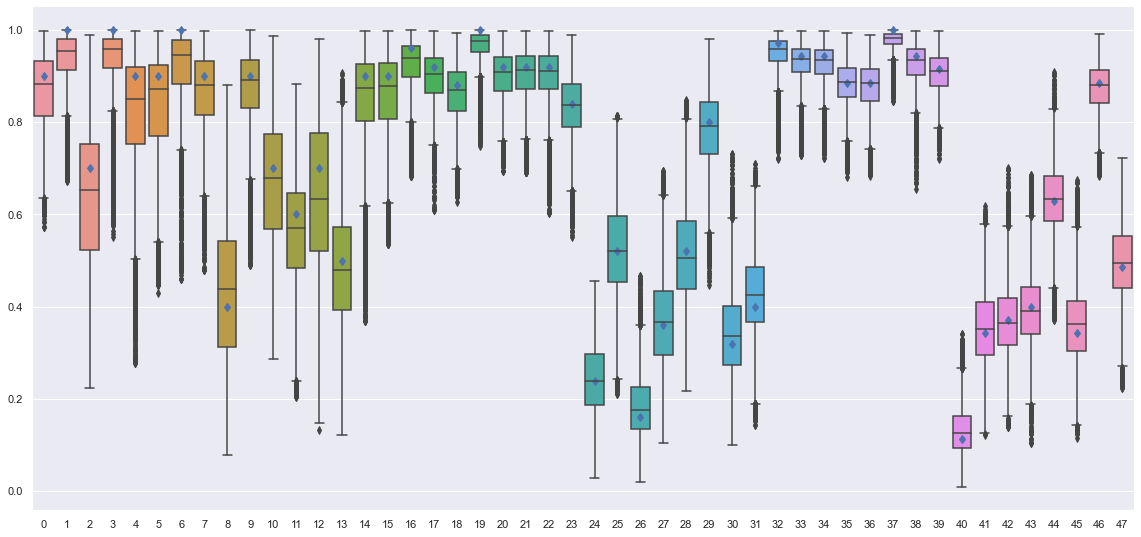

In [45]:
sns.catplot(data=pandas.DataFrame(tf.reshape(tr[0], (-1, 48)).numpy()), kind='box')
plt.plot(frogs.index, frogs.propsurv, 'd')
plt.gcf().set_size_inches(18, 8)

## Pooling Model

$$\begin{align}
\alpha &\sim \operatorname{Normal}(0, 2)\\
\sigma &\sim \operatorname{HalfCauchy}(0, 1)\\
a_i &\sim \operatorname{Normal}(\alpha, \sigma)\\
\theta_i &= \operatorname{logistic}(a_i)\\
s_i &\sim \operatorname{Binomial}(N_i, \theta_i)
\end{align}
$$

In [47]:
def logistic(p):
    return tf.math.exp(p) / (1 + tf.math.exp(p))

In [63]:
pooling_model = tfd.JointDistributionNamedAutoBatched({
    'alpha': tfd.Normal(0, 2),
    'sigma': tfd.HalfCauchy(0, 1),
    'theta': lambda alpha, sigma :tfd.Independent(tfd.Normal(alpha*tf.ones(frogs.shape[0]), sigma)),
    's': lambda theta: tfd.Independent(tfd.Binomial(frogs['density'], probs=logistic(theta)))
})

In [48]:
pooling_model.resolve_graph()

(('sigma', ()),
 ('alpha', ()),
 ('theta', ('alpha', 'sigma')),
 ('s', ('theta',)))

In [49]:
@tf.function
def pooling_log_prob(alpha, sigma, theta):
    return pooling_model.log_prob(
        {'alpha': alpha,
         'sigma': sigma,
         'theta': theta,
         's': surv})

In [50]:
@tf.function
def pooling_sample_chain(nobs, nburn, nchains):
    sample = pooling_model.sample(nchains) # throw away sample for s
    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=pooling_log_prob,
            num_leapfrog_steps=3,
            step_size=0.01
        ),
        num_adaptation_steps=int(0.8*nburn))
    states = tfp.mcmc.sample_chain(
        kernel=kernel,
        num_burnin_steps=nburn,
        num_results=nobs,
        current_state=[
            sample['alpha'],
            sample['sigma'],
            sample['theta']])
    return states

In [51]:
tr_pooling, kr_pooling = pooling_sample_chain(5000, 1000, 4)

/Users/dirkhesse/.pyenv/versions/3.9.6/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [53]:
kr_pooling.inner_results.is_accepted.numpy().mean()

0.7565

In [55]:
tr_pooling

[<tf.Tensor: shape=(5000, 4), dtype=float32, numpy=
 array([[1.6598322, 1.5888729, 1.5016837, 1.1703875],
        [1.0552022, 1.1906809, 1.4567803, 1.6789708],
        [1.4724422, 1.6811236, 1.4567803, 1.2193668],
        ...,
        [1.3557577, 1.1832073, 1.7645457, 1.2386963],
        [1.950095 , 1.5475075, 0.9861453, 1.2007405],
        [1.2006868, 1.2876163, 1.7863233, 1.2007405]], dtype=float32)>,
 <tf.Tensor: shape=(5000, 4), dtype=float32, numpy=
 array([[1.4845858, 1.4127817, 1.4227797, 1.6769102],
        [1.9423263, 1.7752112, 1.4836378, 1.5873448],
        [1.9263442, 1.5594995, 1.4836378, 1.6055398],
        ...,
        [1.8236454, 1.4816883, 1.4915607, 1.8596101],
        [2.3211906, 1.9231224, 1.5890989, 1.3184707],
        [1.9346502, 1.2834662, 1.6822395, 1.3184707]], dtype=float32)>,
 <tf.Tensor: shape=(5000, 4, 48), dtype=float32, numpy=
 array([[[ 4.4580245e+00,  4.0492668e+00,  3.4853816e-03, ...,
          -5.2673244e-01,  2.3217375e+00,  4.1392782e-01],
        

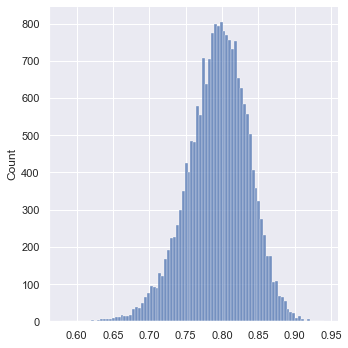

In [59]:
sns.displot(tf.reshape(logistic(tr_pooling[0]), (-1)).numpy())

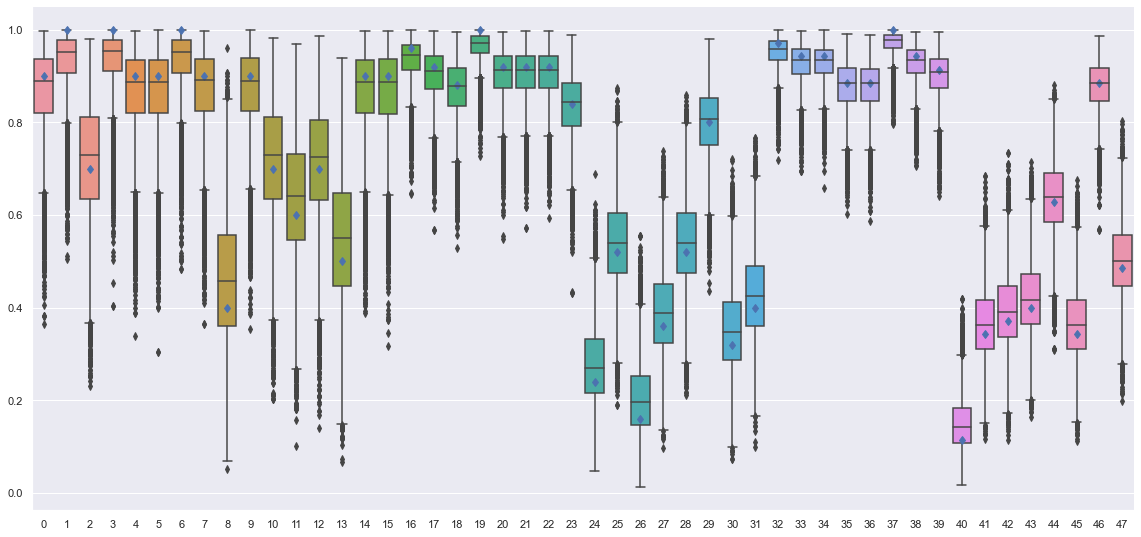

In [61]:
sns.catplot(data=pandas.DataFrame(tf.reshape(logistic(tr_pooling[-1]), (-1, 48)).numpy()), kind='box')
plt.plot(frogs.index, frogs.propsurv, 'd')
plt.gcf().set_size_inches(18, 8)

In [65]:
tfp.mcmc.potential_scale_reduction(tr_pooling)

[<tf.Tensor: shape=(), dtype=float32, numpy=1.0010403>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0029483>,
 <tf.Tensor: shape=(48,), dtype=float32, numpy=
 array([1.0032957 , 1.0162851 , 1.0032014 , 1.0034423 , 1.000331  ,
        1.005807  , 1.0043355 , 1.0034584 , 1.000688  , 1.0002229 ,
        1.0006173 , 1.0003661 , 1.0018457 , 1.001163  , 1.0008967 ,
        1.0011443 , 1.0055776 , 1.0004107 , 1.003336  , 1.0048571 ,
        1.0027169 , 1.0005136 , 1.0030075 , 1.0005587 , 0.99981385,
        1.0000011 , 1.0017562 , 1.0003108 , 1.0007849 , 1.0007653 ,
        1.000334  , 1.000117  , 1.0014032 , 1.0016639 , 1.000521  ,
        1.0008492 , 1.0006292 , 1.005789  , 1.000446  , 1.0000975 ,
        1.0001079 , 1.0006268 , 1.0001785 , 1.0011575 , 0.9998694 ,
        1.0000169 , 1.0003971 , 1.0000731 ], dtype=float32)>]

In [66]:
?tfp.mcmc.potential_scale_reduction

Signature:
tfp.mcmc.potential_scale_reduction(
    chains_states,
    independent_chain_ndims=1,
    split_chains=False,
    validate_args=False,
    name=None,
)
Docstring:
Gelman and Rubin (1992)'s potential scale reduction for chain convergence.

Given `N > 1` states from each of `C > 1` independent chains, the potential
scale reduction factor, commonly referred to as R-hat, measures convergence of
the chains (to the same target) by testing for equality of means.
Specifically, R-hat measures the degree to which variance (of the means)
between chains exceeds what one would expect if the chains were identically
distributed. See [Gelman and Rubin (1992)][1]; [Brooks and Gelman (1998)][2].

Some guidelines:

* The initial state of the chains should be drawn from a distribution
  overdispersed with respect to the target.
* If all chains converge to the target, then as `N --> infinity`, R-hat --> 1.
  Before that, R-hat > 1 (except in pathological cases, e.g. if the chain
  paths were ide